In [1]:
#pip install pmdarima

In [4]:
from math import sin, pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as nr

import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error

import statsmodels.graphics.tsaplots as splt
import statsmodels.api as statsmodels
import statsmodels.formula.api as sm
import statsmodels.tsa.seasonal as sts
import statsmodels.tsa.arima_process as arima_process
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 5]

import warnings
warnings.filterwarnings('ignore')

### Formulas from labs
def decomp_ts(ts, period, model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model, period = period)
    return(pd.DataFrame({'ts': ts, 'trend': res.trend, 'seasonal': res.seasonal, 'resid': res.resid}, 
                        index = ts.index))

def plot_acf_pacf(x, lags = 40):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = splt.plot_acf(x, lags = lags, ax = axes[0])
    fig = splt.plot_pacf(x, lags = lags, ax = axes[1]);
    return None

def plot_ts_resid(x):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = sns.lineplot(x.index, x, ax = axes[0])
    fig = sns.distplot(x, ax = axes[1]);
    return None

In [5]:
CBE = pd.read_csv('data/cbe.csv')
CBE.index = pd.date_range(start = '1-1-1958', end = '12-31-1990', freq = 'M')

CBE.head()

choc  beer  elec
1958-01-31  1451  96.3  1497
1958-02-28  2037  84.4  1463
1958-03-31  2477  91.2  1648
1958-04-30  2785  81.9  1595
1958-05-31  2994  80.5  1777

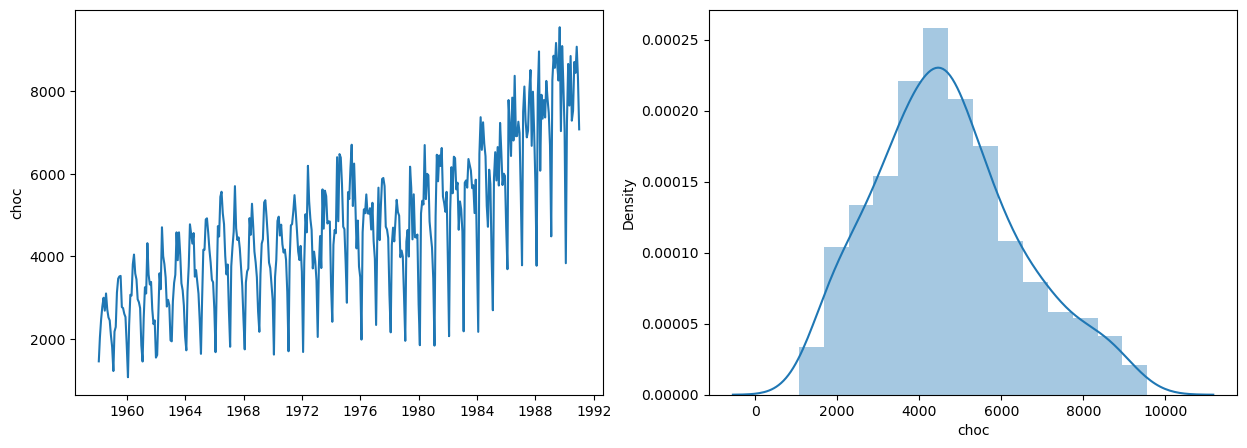

In [6]:
plot_ts_resid(CBE['choc'])
plt.show()

The multiplicative decomposition model can be easily transformed to an additive model by taking the logarithm of the values.

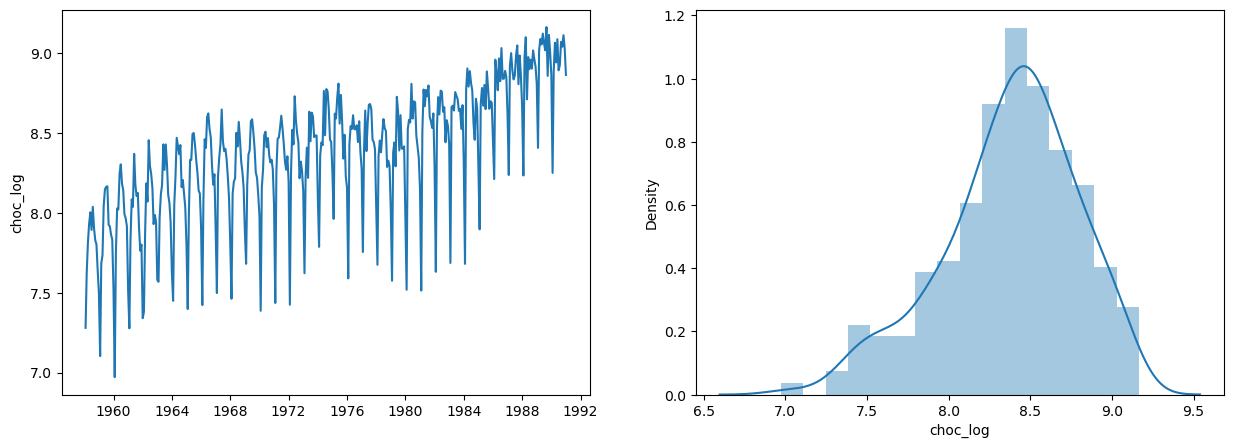

In [7]:
CBE['choc_log'] = np.log(CBE['choc'])
plot_ts_resid(CBE['choc_log'])
plt.show()

### Fitting linear regression for base line purposes and preprocessing

In [8]:
## your code goes here
# part 1
CBE['month_int']=CBE.index.month
CBE['month_sqr']=CBE['month_int'].pow(2)
# part 2
dum = pd.get_dummies(CBE.month_int, prefix='Month')
CBE['month_int_norm']=(CBE['month_int']-CBE['month_int'].mean())/CBE['month_int'].std()
CBE['month_sqr_norm']=(CBE['month_sqr']-CBE['month_sqr'].mean())/CBE['month_sqr'].std()
# part 3
CBE['choc_log_lag_1']=CBE['choc_log'].shift(1)

# combining everything back into the CBE data frame
CBE=pd.concat([CBE, dum], axis=1)

# displaying first 5 rows
CBE.head()

choc  beer  elec  choc_log  month_int  month_sqr  month_int_norm  \
1958-01-31  1451  96.3  1497  7.280008          1          1       -1.591242   
1958-02-28  2037  84.4  1463  7.619233          2          4       -1.301925   
1958-03-31  2477  91.2  1648  7.814803          3          9       -1.012609   
1958-04-30  2785  81.9  1595  7.932003          4         16       -0.723292   
1958-05-31  2994  80.5  1777  8.004366          5         25       -0.433975   

            month_sqr_norm  choc_log_lag_1  Month_1  ...  Month_3  Month_4  \
1958-01-31       -1.151852             NaN        1  ...        0        0   
1958-02-28       -1.086857        7.280008        0  ...        0        0   
1958-03-31       -0.978533        7.619233        0  ...        1        0   
1958-04-30       -0.826878        7.814803        0  ...        0        1   
1958-05-31       -0.631894        7.932003        0  ...        0        0   

            Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  \
1958-01-31        0        0        0        0        0         0         0   
1958-02-28        0        0        0        0        0         0         0   
1958-03-31        0        0        0        0        0         0         0   
1958-04-30        0        0        0        0        0         0         0   
1958-05-31        1        0        0        0        0         0         0   

            Month_12  
1958-01-31         0  
1958-02-28         0  
1958-03-31         0  
1958-04-30         0  
1958-05-31         0  

[5 rows x 21 columns]

Split the data into training and test sets, using the last 12 months of data for testing. And train a linear regression model

In [9]:
from sklearn.linear_model import LinearRegression
# part 1 splitting the data
train_CBE=CBE[:-13].bfill().ffill() # back-filling the beginning and forward-filling the ending as the first row contains a NaN value
test_CBE=CBE[-13:-1] #use the last 12 months for testing
## part 2 train a lin reg model to predict beer_log price
Y = train_CBE['choc_log']
#
column=['month_int_norm','month_sqr_norm','choc_log_lag_1'] + list(dum.columns.values)
X=train_CBE[column]
#model initialization
regression_model = LinearRegression()
#fit the data(train)
regression_model.fit(X,Y)
#predict
train_CBE['predicted_choc_log'] = regression_model.predict(X)

Plot a line plot of the original time series, and to the same plot add line plots to show the predictions on the training data and the test data. Using separate colors for each. 

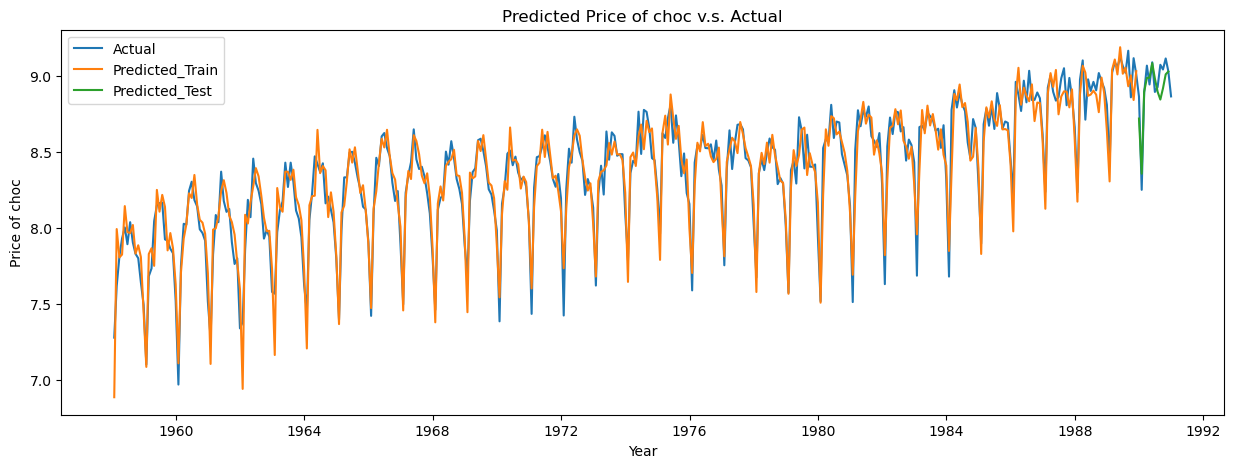

In [10]:
## your code goes here
# create test prediction
test_CBE['predicted_choc_log'] = regression_model.predict(test_CBE[column]) #using same columns but test data frame
# plots

fig = plt.figure()
ax = plt.axes()
plt.plot(CBE.index, CBE['choc_log']) # plot actual
plt.plot(train_CBE.index, train_CBE['predicted_choc_log']) # plot predicted_train
plt.plot(test_CBE.index, test_CBE['predicted_choc_log']) # plot predicted_test
plt.title("Predicted Price of choc v.s. Actual")
plt.xlabel("Year")
plt.ylabel("Price of choc");
plt.legend(['Actual','Predicted_Train','Predicted_Test'])
plt.show()

Compute the **root mean square error (RMSE)** of the model on the test data and plot the line plot and the histogram of the residual (choc price minus forecast)

The RMSE is 0.0106


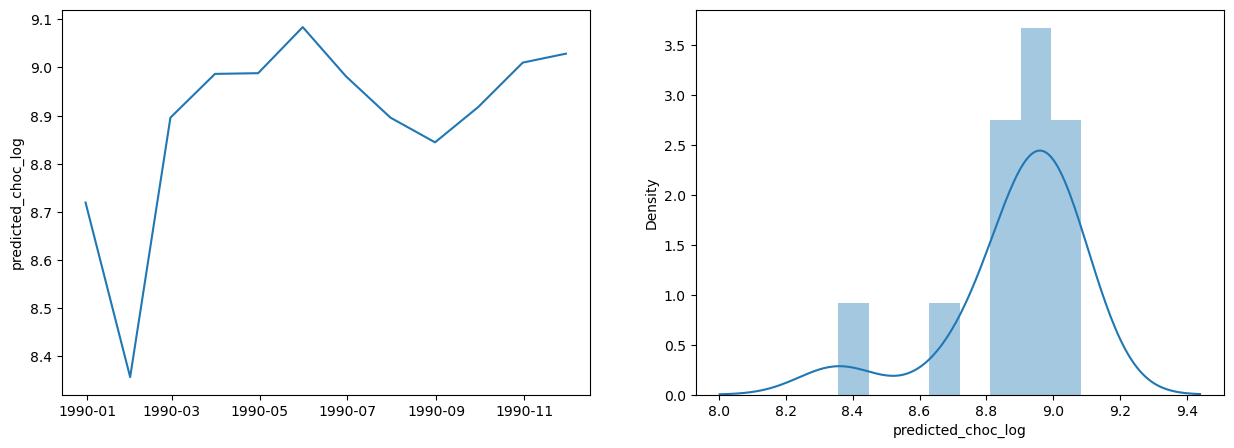

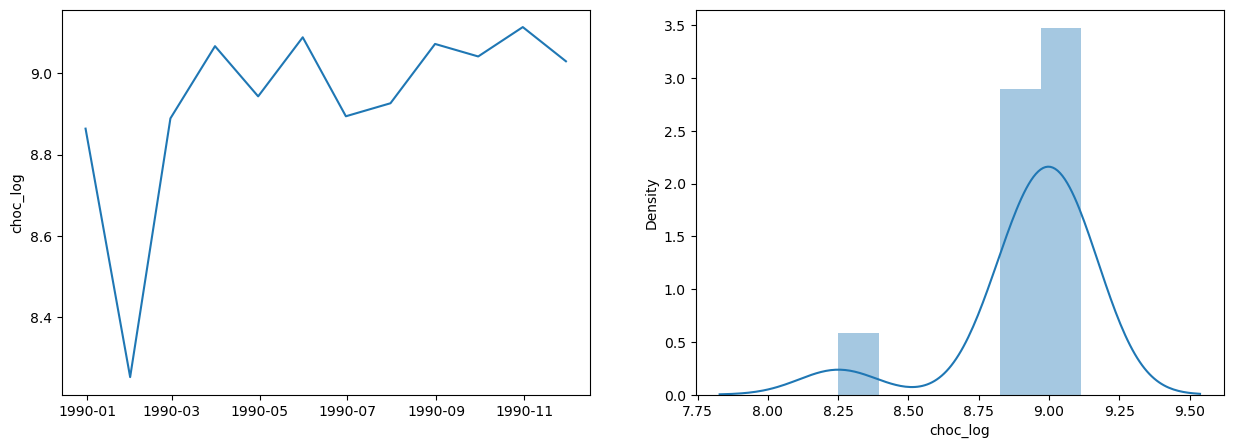

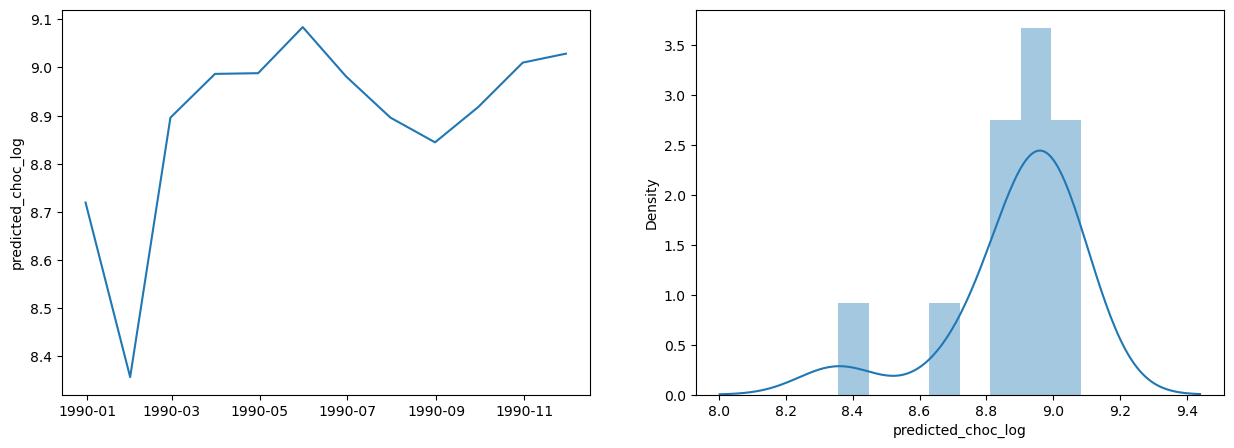

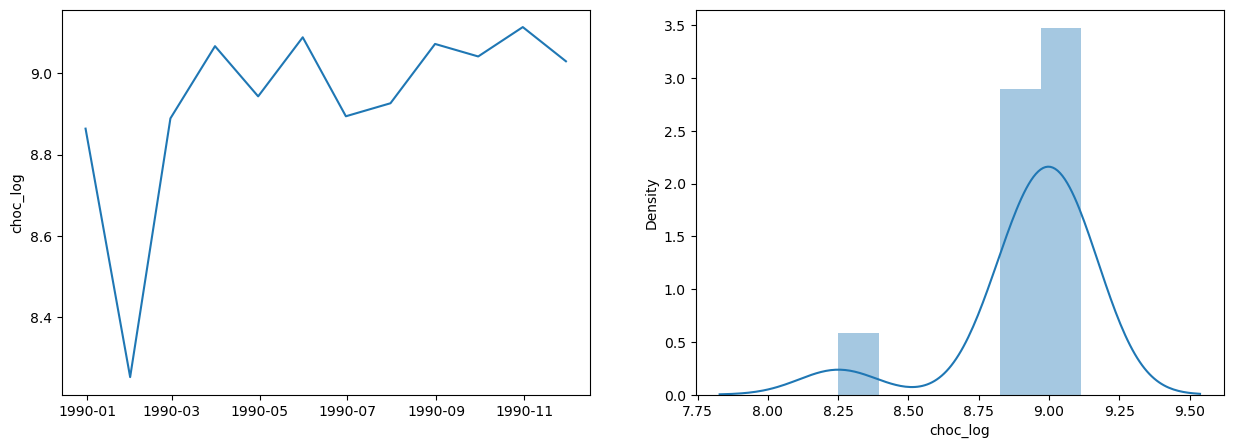

In [12]:
from sklearn.metrics import mean_squared_error
## your code goes here
## part 0 use the model to predict based on the test data
#test_CBE['predicted_choc'] = regression_model.predict(test_CBE[column])
# part 1 calculate RMSE of the predicted test data
rmse=mean_squared_error(y_true=test_CBE['choc_log'],y_pred=test_CBE['predicted_choc_log'])# using test data not training data
print(f'The RMSE is {rmse:.4f}')
# part 2 plot line plot/ histogram of resid
plot_ts_resid(test_CBE['predicted_choc_log'])
plot_ts_resid(test_CBE['choc_log'])
plt.show()

### Conclusions

By evaluating both the train and test model predictions against the actual we can see at a 10,000 foot level that the linear model is relatively accurate at prediction.  By doing additional calculation of the RMSE of the test_log data v.s. the test_log prediction we can see that the RMSE is 0.0101 which when compared to our values of ~4.2-5.3 is quite good and further strengthens our position that we have created a strong model. By evaluating the residuals of the test data v.s. the test prediction we can see that the residuals follow a similar shape with values ranging from ~4.9-5.35. Additionally the histogram shows the values are centered around 5.0 with a second peak at about 3.5.  All of the above leads us to believe the model created has a strong ability to accurately predict the beer_log price to a reasonable degree.

### Fitting a time series model

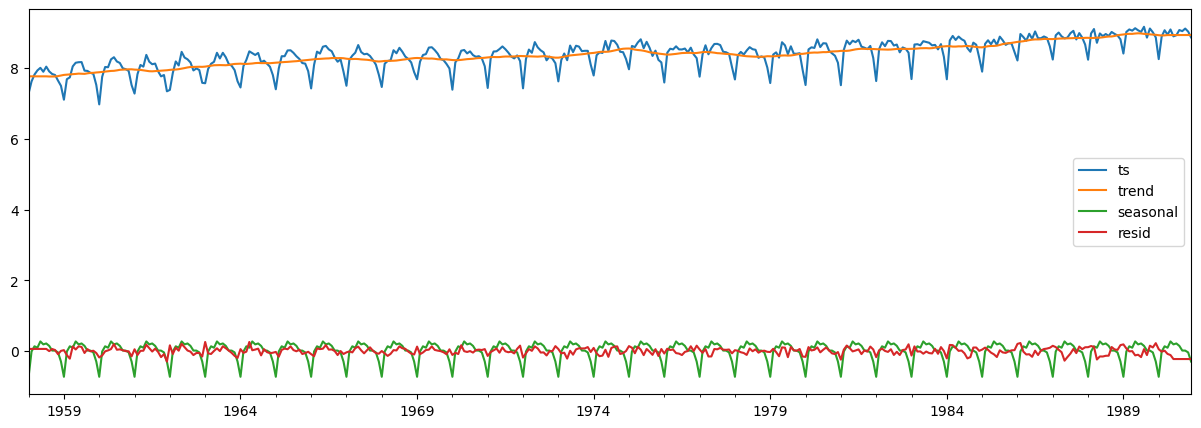

In [13]:
## your code goes here
decomp = decomp_ts(CBE['choc_log'], period = 12).bfill().ffill() # use helper function and remove NaNs
#plot
decomp.plot()
plt.show()

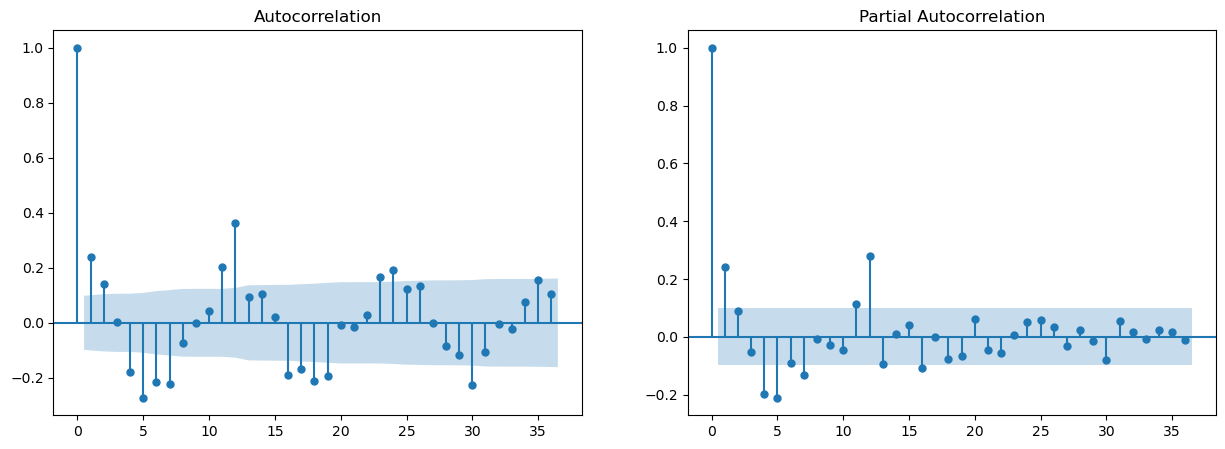

In [14]:
## your code goes here
plot_acf_pacf(decomp['resid'], lags = 36)
plt.show()

In [12]:
CBE.index[-13]

Timestamp('1989-12-31 00:00:00', freq='M')

In [15]:
validation_cut_off=CBE.index[-13]
from pmdarima import auto_arima
best_fit = auto_arima(CBE.loc[:validation_cut_off, 'choc_log'], 
                      max_p = 3, max_d = 1, max_q = 3, 
                      m = 12, max_P = 1, max_D = 1, max_Q = 1, 
                      information_criterion = 'bic', 
                      trace = True, error_action = 'ignore', suppress_warnings = True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=-569.481, Time=1.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=151.380, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-143.839, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=145.510, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : BIC=inf, Time=1.51 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : BIC=inf, Time=1.77 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : BIC=-589.202, Time=1.48 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : BIC=-206.225, Time=1.26 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : BIC=-512.541, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : BIC=-571.625, Time=1.31 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : BIC=-585.017, Time=1.51 sec
 ARIMA(1,1,3)(1,0,1)[12] intercept   : BIC=-56

Let's take a look at the best model's summary:

In [17]:
print(best_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  384
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 315.051
Date:                            Tue, 31 Aug 2021   AIC                           -622.102
Time:                                    21:13:37   BIC                           -606.310
Sample:                                         0   HQIC                          -615.838
                                            - 384                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7909      0.031    -25.670      0.000      -0.851      -0.730
ar.S.L12       0.9938      0.003   

In [16]:
from pmdarima import auto_arima
best_fit = auto_arima(CBE.loc[:validation_cut_off, 'choc_log'], 
                      max_p = 3, max_d = 1, max_q = 3, 
                      m = 12, max_P = 1, max_D = 1, max_Q = 1, 
                      information_criterion = 'bic', 
                      trace = True, error_action = 'ignore', suppress_warnings = True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=-569.481, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=151.380, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-143.839, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=145.510, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : BIC=inf, Time=1.48 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : BIC=inf, Time=1.72 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : BIC=-589.202, Time=1.45 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : BIC=-206.225, Time=1.31 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : BIC=-512.541, Time=1.04 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : BIC=inf, Time=0.49 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : BIC=-571.625, Time=1.35 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : BIC=-585.017, Time=1.47 sec
 ARIMA(1,1,3)(1,0,1)[12] intercept   : BIC=-56

Let's now visualize the forecast. With time series models we use the `predict_in_sample` to make predictions for the range of data that we used during training, and we use `predict` to make forecasts.

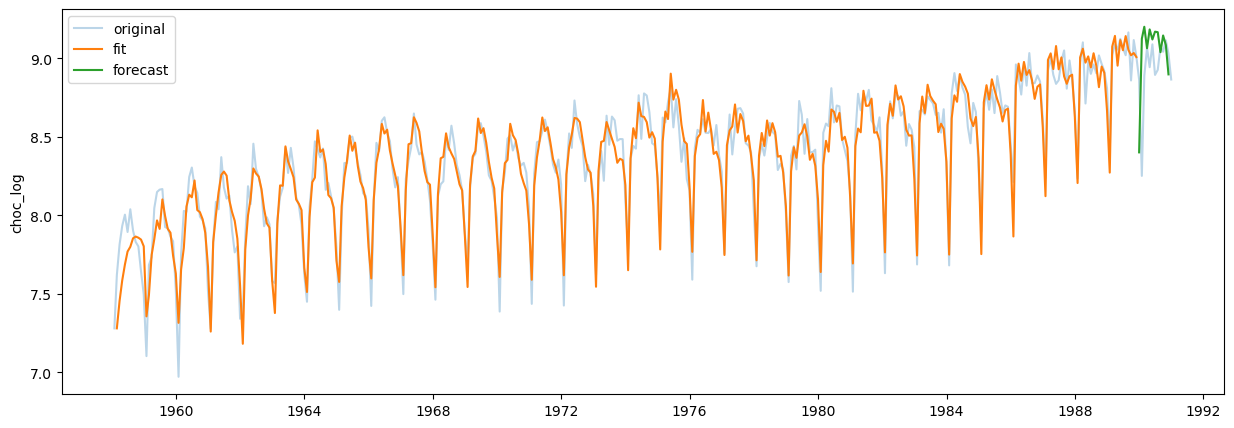

In [18]:
#played around with some variable names to make things work with my code above.
start_idx = 1
train_idx = train_CBE.reset_index().index[start_idx:]
n_periods = len(test_CBE)

sns.lineplot(CBE.index, CBE['choc_log'], alpha = 0.3)
sns.lineplot(train_CBE.index[train_idx], best_fit.predict_in_sample(start = start_idx, end = train_idx.max()))
sns.lineplot(test_CBE.index, best_fit.predict(n_periods = n_periods))
plt.legend(['original', 'fit', 'forecast']);
plt.show()

Compute the RMSE and use `plot_ts_resid` to plot the line plot and the histogram of the residuals. 

The RMSE is 0.1081


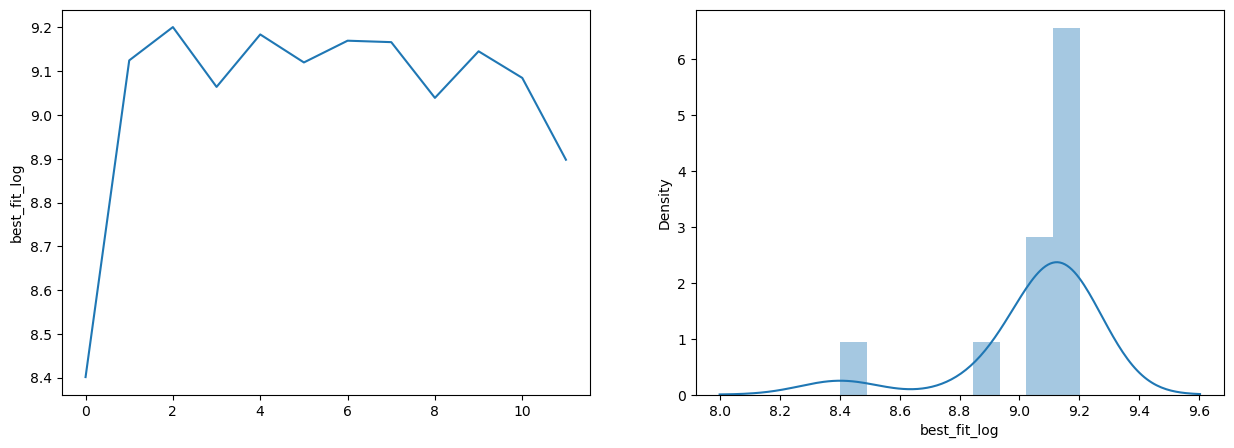

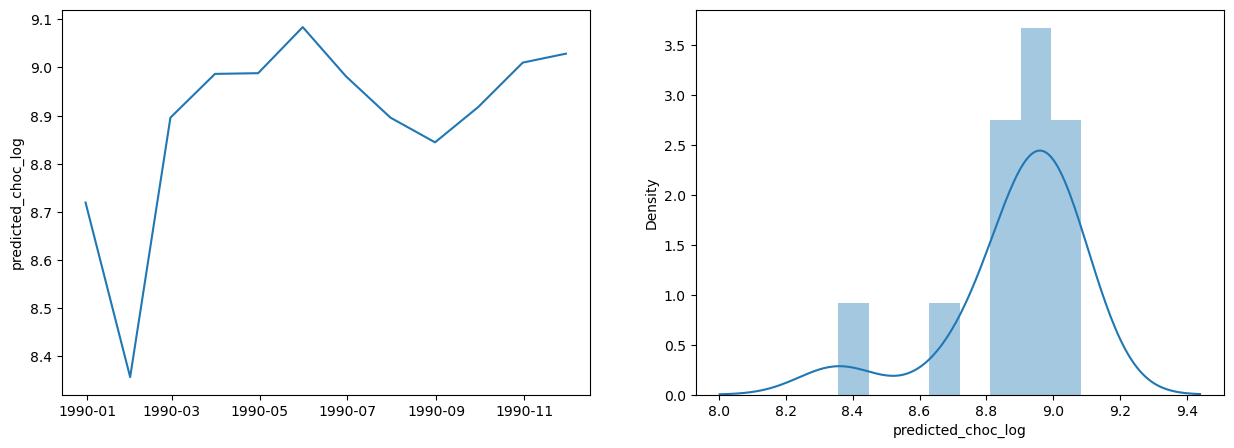

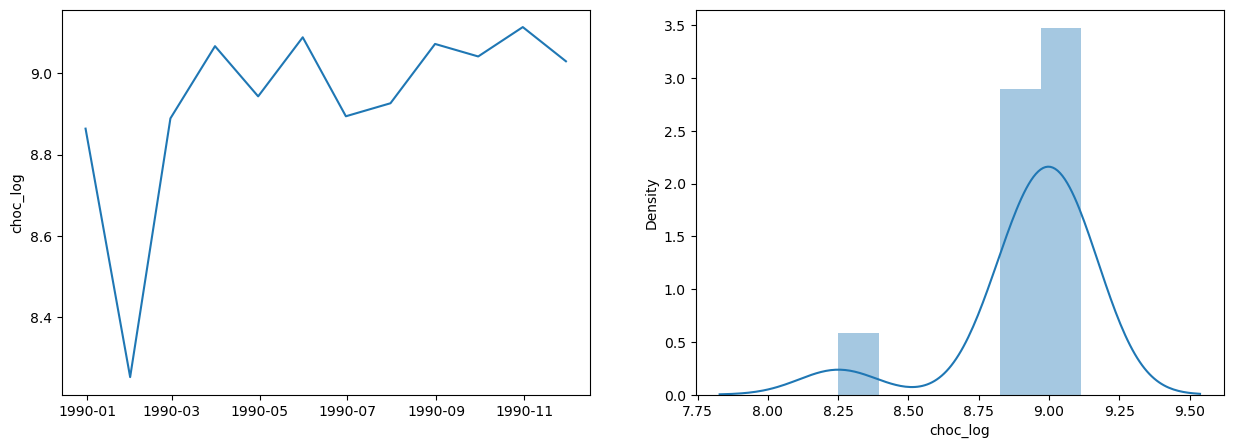

In [19]:
## your code goes here
# part 1 calculate RMSE of the predicted test data
rmse=mean_squared_error(y_true=test_CBE['choc_log'],y_pred=best_fit.predict(n_periods = n_periods))# using test data not training data
print(f'The RMSE is {rmse:.4f}')
# part 2 plot line plot/ histogram of resid
best_fit_predict=best_fit.predict(n_periods = n_periods) #need to change np array to pandas series for helper function to work
plot_ts_resid(pd.Series(best_fit_predict, name='best_fit_log'))
plot_ts_resid(test_CBE['predicted_choc_log'])
plot_ts_resid(test_CBE['choc_log'])
plt.show()